Exercise 2.11 (programming) Make a figure analogous to Figure 2.6 for the nonstationary
case outlined in Exercise 2.5. Include the constant-step-size $\epsilon$-greedy algorithm with
$\alpha= 0.1$. Use runs of $200,000$ steps and, as a performance measure for each algorithm and
parameter setting, use the average reward over the last $100,000$ steps.

In [54]:
import numpy as np
from scipy import special
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from fractions import Fraction
np.random.seed(0)

def experiment(epsilon, N_STEPS, actionValueMethod, alpha , strategy, algorithm, optimisticTerm, UCBParam):
    
    avg_reward = 0
    if strategy == "optimistic":
        Qa, Na = np.repeat(5.,10), np.zeros(10)
    if strategy == "realistic":
        Qa, Na = np.zeros(10), np.zeros(10)
    realQs = np.zeros(10) # Real action value expectation start out from 0 and do random walks (random increment at each timestep)
    preferences = np.zeros(10) # Preferences for the gradient bandit
    avg_reward_grad = 0   # Baseline reward used for the gradient bandit 
    for step in range(N_STEPS):
        action, reward = 0, 0  
        UCBTerm = np.zeros(10) # This is equal to Q_t(a) + sqrt(ln(t)/N_a(t)), where t is current timestep and 
        if algorithm == "EGSA" or algorithm == "EGC" or algorithm == "GO": # Epsilon Greedy Step Average, Epsilon Greedy Constant, Greedy Optimistic 
            prob = random.uniform(0.0, 1.0)
            if prob <= (1.0 - epsilon):
                action = np.argmax(Qa)
                reward = np.random.normal(realQs[action], 1, 1)[0]
                if step >= N_STEPS/2:
                  avg_reward += reward
                if actionValueMethod == "Incremental":
                    Na[action] += 1
                    Qa[action] += (1/Na[action])*(reward-Qa[action])
                elif actionValueMethod == "Constant":
                    Qa[action] += alpha*(reward-Qa[action])
            else:
                action = np.random.randint(0, 10, 1)[0]
                reward = np.random.normal(realQs[action], 1, 1)[0]
                if step >= N_STEPS/2:
                    avg_reward += reward
                if actionValueMethod == "Incremental":
                    Na[action] += 1
                    Qa[action] += (1/Na[action])*(reward-Qa[action])
                elif actionValueMethod == "Constant":
                    Qa[action] += alpha*(reward-Qa[action])
            realQs += np.random.normal(0, 0.01, 10) # random walk for the real q-values
        elif algorithm == "UCB":
            if step < 10: # Mitigating the division by 0
              UCBTerm[step] = 1000 # Just giving it a big value so that it's definite the agent will pick that action
            else:
              for a in range(10):
                UCBTerm[a] = Qa[a] + UCBParam*np.sqrt(np.log(step)/Na[a])
            action = np.argmax(UCBTerm)
            reward = np.random.normal(realQs[action], 1, 1)[0]
            if step >= N_STEPS/2:
                avg_reward += reward
            # update (incremental)
            Na[action] += 1
            Qa[action] += (1/Na[action])*(reward-Qa[action])  
            realQs += np.random.normal(0, 0.01, 10)    
        elif algorithm == "GRAD":
            probabilities = special.softmax(preferences)
            action = np.random.choice(np.arange(0, 10), p=probabilities)
            reward = np.random.normal(realQs[action], 1, 1)[0]
            if step >= N_STEPS/2:
                avg_reward += reward
            if step == 0:
              avg_reward_grad = reward
            else:
              avg_reward_grad += (1/(step+1))*(reward - avg_reward_grad) # In-place update of the baseline reward
            # update (gradient ascent)
            for a in range(10):
              if a == action:
                preferences[a] += 0.1*(reward - avg_reward_grad)*(1-probabilities[a])
              else:
                preferences[a] -= 0.1*(reward - avg_reward_grad)*probabilities[a]
          
    return avg_reward/(N_STEPS/2)

N_STEPS = 200000
ParamsEGSA = [2**(-i) for i in range(7, 1, -1)] # Parameter values (epsilon) for the Epsilon Greedy Step Average Algo
ParamsEGC = ParamsEGSA # Parameter values for the Epsilon Greedy Constant Algo (same as for step average)
ParamsGO = [2**(-i) for i in range(2, -3, -1)] # Parameter values (initial action values) for the Greedy Optimistic Algo
ParamsUCB = [2**(-i) for i in range(4, -3, -1)] # Parameter values (scaling factor c) for the UCB Algo
ParamsGRAD = [2**(-i) for i in range(5, -3, -1)] # Parameter values (gradient step size) for Gradient Algo

avg_rewards_EGSA = []
for param in ParamsEGSA:
    avg_rewards_EGSA.append(experiment(param, N_STEPS, "Incremental",  0.1, "realistic","EGSA", 0, 1))

avg_rewards_EGC = []
for param in ParamsEGC:
    avg_rewards_EGC.append(experiment(0.1, N_STEPS, "Constant",  param, "realistic","EGC", 0, 1))

avg_rewards_GO = []
for param in ParamsGO:
    avg_rewards_GO.append(experiment(0.1, N_STEPS, "Incremental",  0.1, "optimistic","GO", param, 1))

avg_rewards_UCB = []
for param in ParamsUCB:
    avg_rewards_UCB.append(experiment(0.1, N_STEPS, "Incremental",  0.1, "realistic", "UCB", 0, param))

avg_rewards_GRAD = []
for param in ParamsGRAD:
    avg_rewards_GRAD.append(experiment(0.1, N_STEPS, "Incremental",  param, "realistic", "UCB", 0, 1))

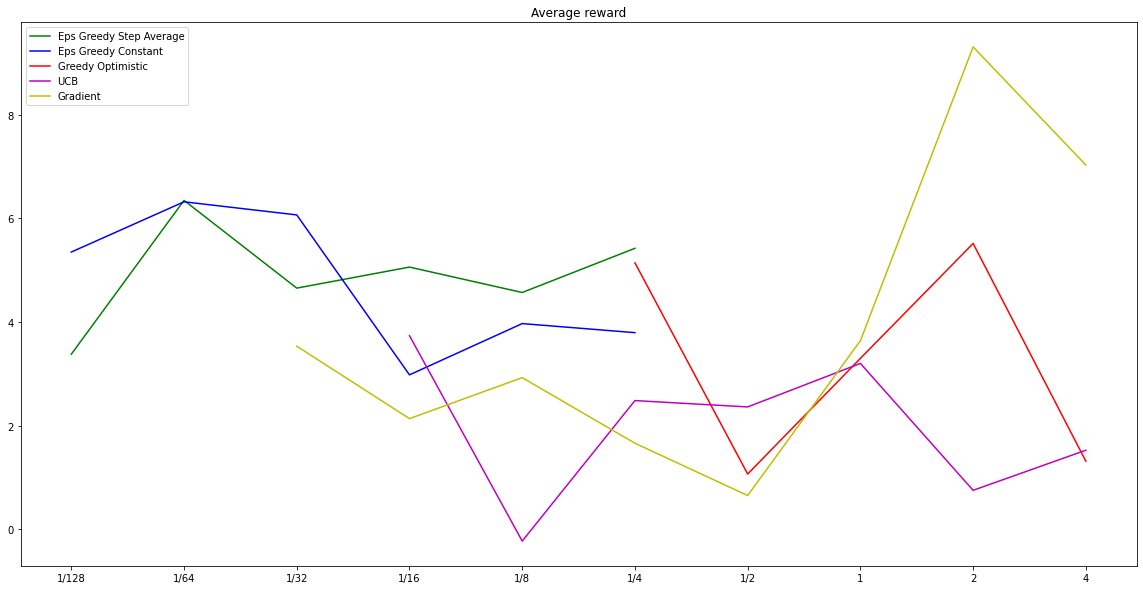

In [66]:
x_ticks = ["1/128", "1/64", "1/32", "1/16", "1/8", "1/4", "1/2", "1", "2", "4"]
x = np.arange(10)
plt.figure(figsize=(20,10))
plt.xticks(x, x_ticks)
plt.plot(x[:6].astype("str"), avg_rewards_EGSA, c= 'g', label = 'Eps Greedy Step Average') 
plt.plot(x[:6].astype("str"), avg_rewards_EGC,  c= 'b', label = 'Eps Greedy Constant')
plt.plot(x[5:].astype("str"), avg_rewards_GO,  c= 'r', label = 'Greedy Optimistic')
plt.plot(x[3:].astype("str"), avg_rewards_UCB,  c= 'm', label = 'UCB')
plt.plot(x[2:].astype("str"), avg_rewards_GRAD,  c= 'y', label = 'Gradient')

plt.legend(loc = "upper left")
plt.title(label = "Average reward")
plt.show()